# 1. ABCs of Gaussian Processes

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.config import default_float
from gpflow.utilities import print_summary
import matplotlib.pyplot as plt
from utils import plot, NLLLoss

A Gaussian Process (GP) is a generalisation of a multivariate Gaussian random variable, in which the states can take values in *the space of functions* $f : X \rightarrow Y$. More precisely, we say that a random variable $f : \Omega \times X \rightarrow Y$ is a *Gaussian process* if for any points $x_1, \ldots, x_N$ belonging to the set $X$, the random variables $f_i := f(\cdot, x_i)$ for $i=1, \ldots, N$ are jointly Gaussian in the usual sense.

Crucially, GPs can be characterised completely using only two objects:
1. The mean function $m : X \rightarrow Y$, and
2. The kernel $k : X \times X \rightarrow Y$.

This is akin to how multivariate Gaussians can be characterised using only the mean and covariance.

The mean function, as the name suggests, outputs the mean of the random variables $f(x)$ at each point $x$ in the set $X$, that is, $m(x) = \mathbb{E}[f(x)])$ and the kernel on the other hand outputs the covariance between the random variables $f(x)$ and $f(x')$ at any points $x$ and $x'$ in $X$, that is, $k(x, x') = \text{Cov}[f(x), f(x')]$.

To visualise Gaussian processes numerically, we select $N$ query points $\mathbf{X} = (x_1, \ldots, x_n)$ from the input space $X$ (usually placed on a grid), compute the mean $\mathbf{m} = m(\mathbf{X})$ and covariance $\mathbf{K} = k(\mathbf{X}, \mathbf{X})$ at the $N$ query points (note: the former is an $N$-dimensional vector and the latter is an $N \times N$ matrix) and plot the results.

**Remark:** For $\mathbf{X} = x_1, \ldots, x_N$, we employ the notation $\mathbf{m} = m(\mathbf{X})$ to denote a vector whose components are $m_i = m(x_i)$ for all $i = 1, \ldots, N$ and $\mathbf{K} = k(\mathbf{X}, \mathbf{X})$ to denote a matrix whose components are $K_{ij} = K(x_i, x_j)$ for all $i, j = 1, \ldots, N$.

In [2]:
# Generate query locations to evaluate GP
num_points = 100
X_query = tf.linspace(0, 10, num_points)[:, None] # Size (num_points, 1)

# Set a mean function (here, we simply choose the zero function)
m = lambda x : tf.zeros_like(x)

# Choose a kernel from the GPflow kernels class
k = gpflow.kernels.SquaredExponential()

# Compute the mean and covariance at the query locations
mean = m(X_query)                           # Size (num_points, 1)
cov = k.K(X_query)                          # Size (num_points, num_points)
var = tf.linalg.diag_part(cov)[:, None]     # Size (num_points, 1)

In the cell above, we chose the Squared Exponential (SE) kernel, which has the functional expression
\begin{align}
    k(x, x') = \sigma^2 \exp\left(-\frac{\|x - x'\|^2}{2 l^2}\right),
\end{align}
where $\sigma^2$ and $l$ are hyperparameters of the kernel that control respectively, the variance (how large are the uncertainties in unobserved regions) and lengthscale (how wiggly are the samples) of the process.
You can tweak the values to see how these hyperparameters affect the plot.

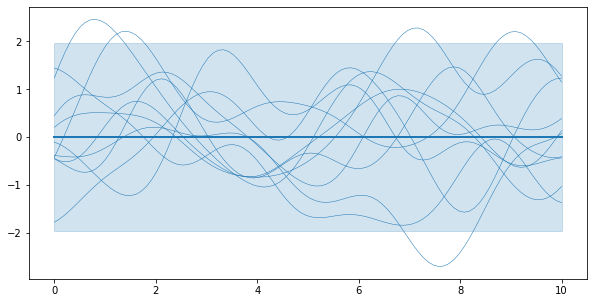

In [3]:
# Visualise GP by plotting the mean, 95% confidence region and samples
# You can set different values of the kernel variance and lengthscale as follows
k.variance.assign(1.0)
k.lengthscales.assign(1.0)

samples = []
num_samples = 10
jitter = 1e-9
SEED = 0
for n in range(num_samples):
    tf.random.set_seed(SEED)
    cho = tf.linalg.cholesky(cov + jitter*tf.eye(num_points, dtype=tf.float64))
    noise = tf.random.normal(X_query.shape, dtype=default_float())
    samples.append(mean + cho@noise)
    SEED += 1
samples = tf.convert_to_tensor(samples)

plot(X_query, mean, var, samples)

The samples in the above cell were obtained by sampling from the multivariate Gaussian $\mathbf{f} \sim N(\mathbf{m}, \mathbf{K})$. In practice, this is done by first sampling from $\mathbf{w} \sim N(\mathbf{0}, \mathbf{I})$ and then transforming it by $\mathbf{f} = \mathbf{m} + \mathbf{K}^{1/2} \mathbf{w}$, where $\mathbf{K}^{1/2}$ is the Cholesky factor of $\mathbf{K}$. Note that in the code above, we added a small 'jitter' to the matrix $\mathbf{K}$ before doing Cholesky factorisation. This is because the condition number of $\mathbf{K}$ is very high, making it seem non-invertible to the computer (in theory however, the matrix is always invertible). This necessitates adding a small 'jitter' to the diagonals in order to make it invertible, which is required for Cholesky decomposition to work.

Next, we illustrate how GPs can be used to interpolate between datapoints by using an example similar to [this example in the GPflow documentation](https://gpflow.readthedocs.io/en/develop/notebooks/intro_to_gpflow2.html).

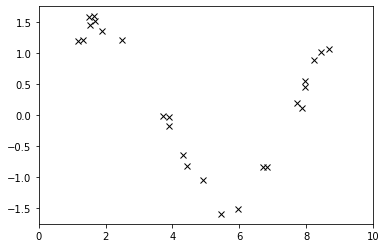

In [4]:
# Generate data points to condition GP
tf.random.set_seed(298923)

def noisy_sin(x, amplitude, lengthscale, noise_std):
    return amplitude*tf.math.sin(x/lengthscale) + noise_std * tf.random.normal(x.shape, dtype=default_float())


num_train_data, num_test_data = 25, 100

X_train = 1 + tf.random.uniform((num_train_data, 1), dtype=default_float()) * 8
X_test = tf.linspace(0, 10, num_test_data)[:, None]

noise_std = 0.1
amplitude = 1.5
lengthscale = 1.2
Y_train = noisy_sin(X_train, amplitude, lengthscale, noise_std)
Y_test = noisy_sin(X_test, amplitude, lengthscale, noise_std)

data = (X_train, Y_train)

plt.plot(X_train, Y_train, "xk")
plt.xlim((0, 10))
plt.show()

In [5]:
# Set up GP model
gp = gpflow.models.GPR(data=(X_train, Y_train), kernel=k, mean_function=m)
print_summary(gp)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

Interpolating between datapoints $(\mathbf{X}, \mathbf{Y})$ is achieved by modelling the latent relation between the $X$ and $Y$-variables using a Gaussian process $f: \Omega \times X \rightarrow Y$ and updating our belief of $f$ upon observing $(\mathbf{X}, \mathbf{Y})$ using Bayes' rule.

More specifically, let $\mathbf{X}_* = (x_{1*}, \ldots, x_{N*})$ be $N_*$ query points where we want our predictions, and $\mathbf{f}, \mathbf{f}_*$ be the predictive values of $f$ at locations $\mathbf{X}$ and $\mathbf{X}^*$ respectively. Assuming that the observations $\mathbf{Y}$ are conditionally independent of $\mathbf{X}_*$ and $\mathbf{f}_*$ given $\mathbf{X}$ (which is usually the case), we have the following:
\begin{align*}
p(\mathbf{f}_* | \mathbf{Y}, \mathbf{X}, \mathbf{X}_*) &= \int p(\mathbf{f}, \mathbf{f}_* | \mathbf{Y}, \mathbf{X}, \mathbf{X}_*) \mathrm{d} \mathbf{f} \\
&= \int \frac{p(\mathbf{Y} | \mathbf{f}, \mathbf{f}_*, \mathbf{X}, \mathbf{X}_*) p(\mathbf{f}, \mathbf{f}_* | \mathbf{X}, \mathbf{X}_*)}{p(\mathbf{Y} | \mathbf{X}, \mathbf{X}_*)} \mathrm{d} \mathbf{f} \\
&= \int \frac{p(\mathbf{Y} | \mathbf{f}, \mathbf{X}) p(\mathbf{f}, \mathbf{f}_* | \mathbf{X}, \mathbf{X}_*)}{p(\mathbf{Y} | \mathbf{X})} \mathrm{d} \mathbf{f}.
\end{align*}

Let us remark on the terms that appear in the final expression:

- The prior distribution $p(\mathbf{f}, \mathbf{f}_* | \mathbf{X}, \mathbf{X}_*)$ is simply by the mean and covariance of the GP at $\mathbf{X}$ and $\mathbf{X}^*$:
\begin{align*}
\begin{pmatrix}
\mathbf{f} \\ \mathbf{f}_*
\end{pmatrix} \sim
\mathcal{N}
\left(
\begin{pmatrix}
m(\mathbf{X}) \\ m(\mathbf{X}_*)
\end{pmatrix}, 
\begin{pmatrix}
k(\mathbf{X}, \mathbf{X}) & k(\mathbf{X}, \mathbf{X}_*) \\
k(\mathbf{X}_*, \mathbf{X}) & k(\mathbf{X}_*, \mathbf{X}_*)
\end{pmatrix}
\right).
\end{align*}

- The likelihood $p(\mathbf{Y} | \mathbf{f}, \mathbf{X})$ can in principle be anything. Here, we choose a Gaussian likelihood of the form
\begin{align*}
p(\mathbf{Y} | \mathbf{f}, \mathbf{X}) = \prod_{i=1}^N \mathcal{N}\left(y_i | f_i, \sigma_{\text{obs}}^2\right),
\end{align*}
where $\sigma_\text{obs}^2$ is the observation noise variance.

- Owing to the Gaussianity of the likelihood $p(\mathbf{Y} | \mathbf{f}, \mathbf{X})$ above, the marginal likelihood $p(\mathbf{Y} | \mathbf{X})$ can be computed explicitly as
\begin{align*}
p(\mathbf{Y} | \mathbf{X}) &= \int p(\mathbf{Y} | \mathbf{f}, \mathbf{X}) \mathrm{d} \mathbf{f}
&= \mathcal{N}(\mathbf{Y} | m(\mathbf{X}), k(\mathbf{X}, \mathbf{X}) + \sigma_{\text{obs}}^2 \mathbf{I}).
\end{align*}
As we will see, the marginal likelihood is a very useful quantity, which can be used for model selection and hyperparameter search.

Since all of the above quantities are Gaussian, we can calculate the mean $\mu_*$ and covariance $\Sigma_*$ of the posterior $\mathbf{f}_* | \mathbf{Y}, \mathbf{X}, \mathbf{X}_*$ explicitly, which reads
\begin{align*}
\mu_* &= k(\mathbf{X}_*, \mathbf{X})\left[k(\mathbf{X}, \mathbf{X}) + \sigma_\text{obs}^2 \mathbf{I}\right]^{-1} (\mathbf{Y} - m(\mathbf{X}))\\
\Sigma_* &= k(\mathbf{X}_*, \mathbf{X}_*) - k(\mathbf{X}_*, \mathbf{X})\left[k(\mathbf{X}, \mathbf{X}) + \sigma_\text{obs}^2 \mathbf{I}\right]^{-1}k(\mathbf{X}, \mathbf{X}_*)
\end{align*}

In GPflow, all of this is taken care of by the `predict_f` method.

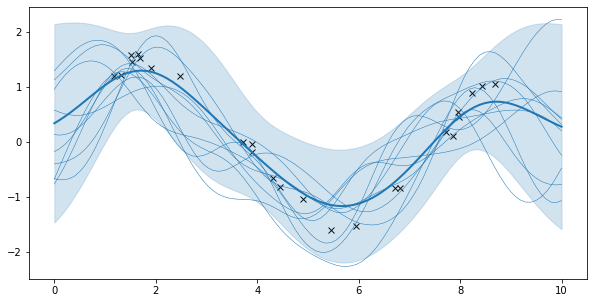

Log marginal likelihood: -30.01138883299992
Negative log likelihood: -0.8985895762375202


In [6]:
# Plot posterior
mean, var = gp.predict_f(X_test)
samples = gp.predict_f_samples(X_test, num_samples)
plot(X_test, mean, var, samples, data)
plt.savefig("figs/fitting_sine_without_training.png", dpi=200)
plt.show()

# Display metrics
negative_log_likelihood = NLLLoss(Y_test, mean, var).numpy()
log_marginal_likelihood = gp.log_marginal_likelihood().numpy()
print(f"Log marginal likelihood: {log_marginal_likelihood}")
print(f"Negative log likelihood: {negative_log_likelihood}")

We see that the GP has conditioned on the data successfully, however there is still room for improvement as the predictions above are underconfident (i.e. the uncertainty bars are larger than necessary). This is due to our choice of kernel hyperparameters, which doesn't reflect the data accurately. Better choices of kernel hyperparameters can be found by maximising the marginal likelihood (equivalently, maximising the log marginal likelihood), which can be achieved via gradient descent or variants thereof.

In [7]:
# Train GP on data to find better hyperparameters
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gp.training_loss, gp.trainable_variables, options=dict(maxiter=100))
print_summary(gp)

2022-02-15 11:28:22.613061: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.20812   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.30589   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0142198 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

We see that compared to the hyperparameter settings before training, the likelihood variance (i.e. observation noise) has decreased significantly and the kernel variance and lengthscale has increased by two-fold. Let's see how these new hyperparameter settings affect our predictions.

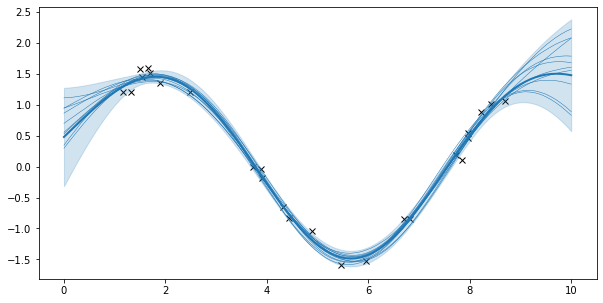

Log marginal likelihood (after training): 3.103434424428137
Negative log likelihood (after training): -2.2444009198415102


In [8]:
# Plot posterior after training
mean, var = gp.predict_f(X_test)
samples = gp.predict_f_samples(X_test, num_samples)
plot(X_test, mean, var, samples, data)
plt.savefig("figs/fitting_sine_after_training.png", dpi=200)
plt.show()

# Display metrics
negative_log_likelihood_trained = NLLLoss(Y_test, mean, var).numpy()
log_marginal_likelihood_trained = gp.log_marginal_likelihood().numpy()
print(f"Log marginal likelihood (after training): {log_marginal_likelihood_trained}")
print(f"Negative log likelihood (after training): {negative_log_likelihood_trained}")

Clearly, we see a better fit on the data. The metrics reflect this, with a higher log marginal likelihood and lower negative log likelihood score.

Below, we plot the log marginal likelihood landscape with respect to the kernel lengthscale and likelihood variance, while keeping the other fixed at the trained values.

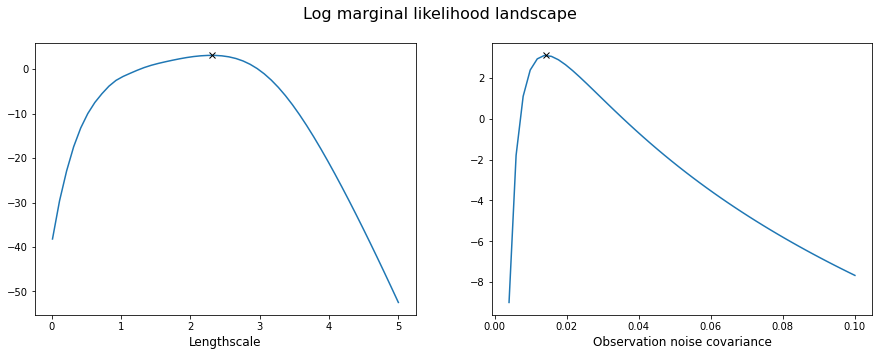

In [9]:
# Extract trained hyperparameter values
lengthscale_trained = gp.kernel.lengthscales.numpy()
kernel_variance_trained = gp.kernel.variance.numpy()
likelihood_variance_trained = gp.likelihood.variance.numpy()

# Plot log marginal likelihood landscape
ls_grid = tf.linspace(1e-2, 5, 50)
var_grid = tf.linspace(4e-3, 1e-1, 50)
marginal_likelihood_ls = []
marginal_likelihood_var = []
for ls, var in zip(ls_grid, var_grid):
    # Vary lengthscale with variance fixed at trained value
    gp.likelihood.variance.assign(likelihood_variance_trained)
    gp.kernel.lengthscales.assign(ls)
    marginal_likelihood_ls.append(gp.log_marginal_likelihood().numpy())
    # Vary variance with lengthscale fixed at trained value
    gp.kernel.lengthscales.assign(lengthscale_trained)
    gp.likelihood.variance.assign(var)
    marginal_likelihood_var.append(gp.log_marginal_likelihood().numpy())

gp.likelihood.variance.assign(likelihood_variance_trained)
gp.kernel.lengthscales.assign(lengthscale_trained)
optima = gp.log_marginal_likelihood().numpy()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.plot(ls_grid, np.array(marginal_likelihood_ls))
ax1.plot(lengthscale_trained, np.array(log_marginal_likelihood_trained), "xk")
ax1.set_xlabel("Lengthscale", fontsize=12)
ax2.plot(var_grid, np.array(marginal_likelihood_var))
ax2.plot(likelihood_variance_trained, np.array(log_marginal_likelihood_trained), "xk")
ax2.set_xlabel("Observation noise covariance", fontsize=12)
plt.suptitle("Log marginal likelihood landscape", fontsize=16)
plt.show()

The star (*) in the plot indicates the value of the log marginal likelihood after training and the respective values of the lengthscale and noise covariance.